# Assignment 3. Introduction to Model Training

*Foundations of Data Science*  
*Dr. Khalaj (Fall 2023)*  

*For your questions refer to @danialayati on Telegram*

### Description  
This homework consists of five questions, each aimed at one skill you are supposed to learn and get comfortable with during the course.  
1. You are supposed to perform an observational study based on **propensity score matching**, as you learned during the course.  
   
2. Briefly introduces you to the usage of sklearn library as well as the very basics of word vectorization.  
   
3. Part 3 and 4 are aimed at getting you familiarized with workflow of regression and classification tasks.  
   
4. For bonus part, you should get familiarized with the basics of PyTorch.   

### Information  
Complete the information box below.

In [1]:
full_name = 'Danial Ataei'
student_id = '99100455'

## 1 Propensity score matching

In this exercise, you will apply propensity score matching that was discussed the lecture ("Observational studies"), in order to draw conclusions from an observational study. [(a reference that could help if you are interested in the concept)](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), 

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](https://www.jstor.org/stable/1806062)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### 1.1 A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups using plots, such as histograms, and other statistical measures, such as mean, median, variance, and standard deviation.

To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?



In [60]:
data = pd.read_csv('lalonde.csv')
data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [3]:
data[data['treat'] == 1].describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [4]:
data[data['treat'] == 0].describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


C:\Users\Dan\AppData\Local\Temp\ipykernel_7300\2654170355.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


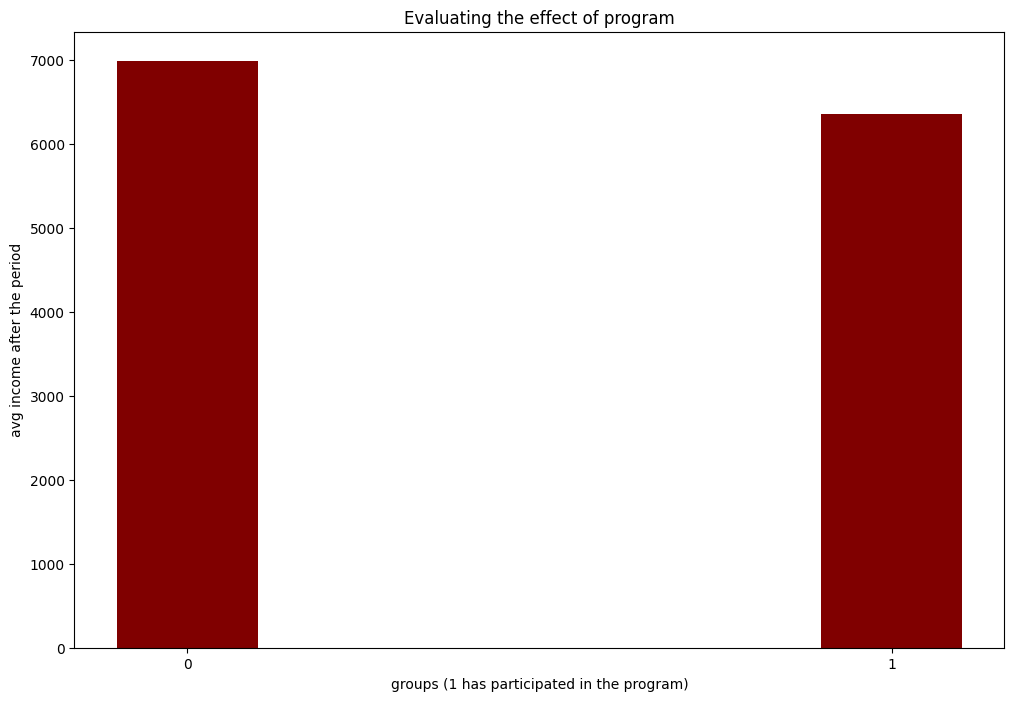

In [5]:
compare = data[['treat', 're78']]
compare_plot = compare.groupby('treat').agg('mean')
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel('groups (1 has participated in the program)')
ax.set_ylabel('avg income after the period')
ax.set_title("Evaluating the effect of program")
ax.set_xticks(compare_plot.index)
ax.bar(compare_plot.index, compare_plot['re78'], color='maroon', width=0.2)
fig.show();

Without checking anything else, a naive researcher will infer that people who participated in the program have less income than those who didn't!

### 1.2 A closer look at the data

You're not naive, of course, so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.


c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

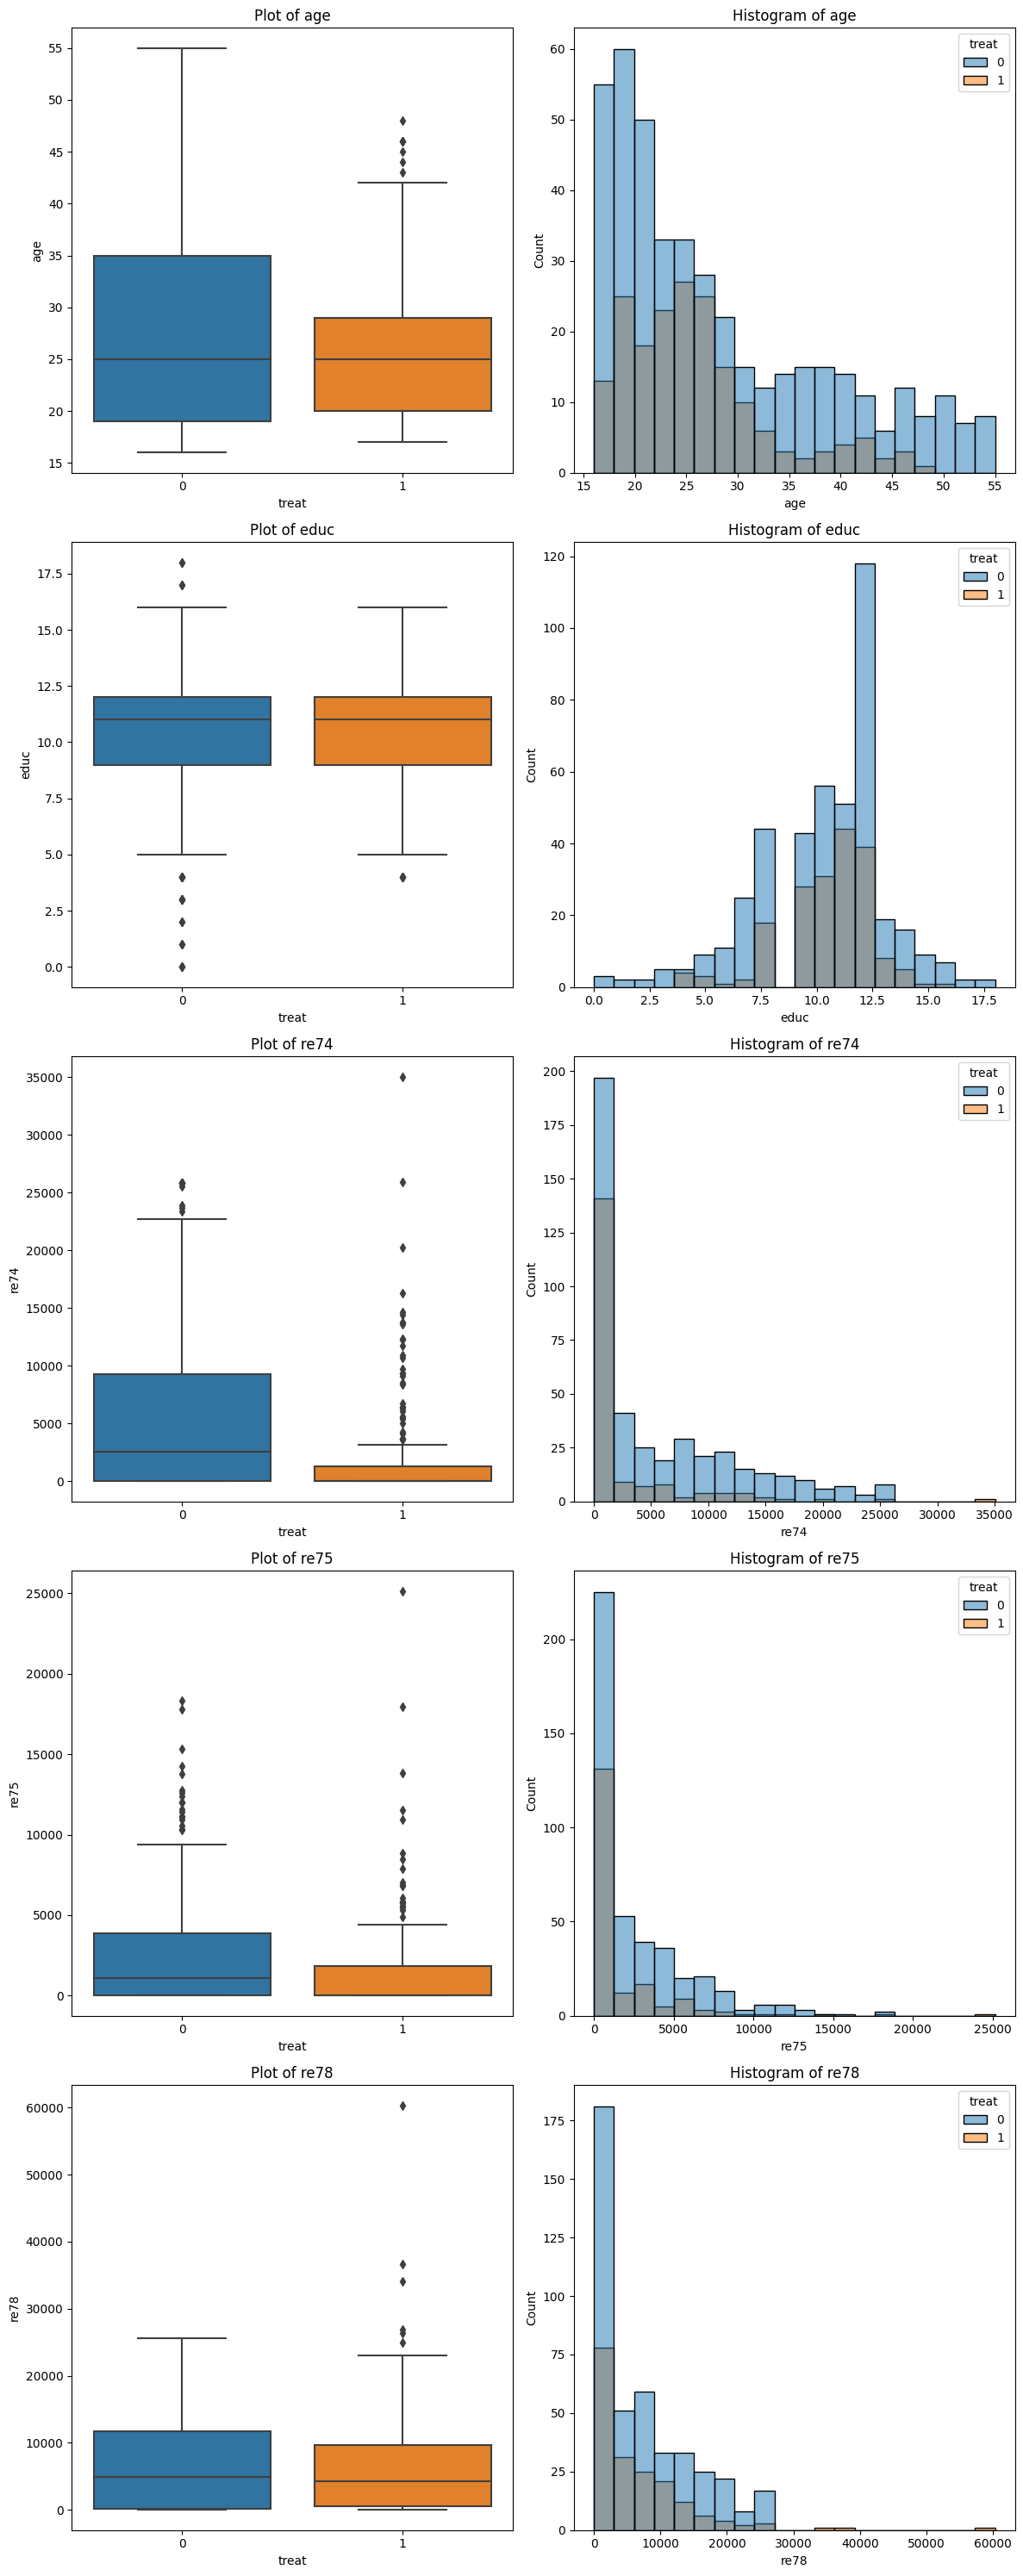

In [6]:
numerical_columns = ['age', 'educ', 're74', 're75', 're78']
fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=2, figsize=(12, 6 * len(numerical_columns)))

for i, col in enumerate(numerical_columns):
    sns.boxplot(x='treat', y=col, data=data, ax=axes[i, 0])
    axes[i, 0].set_title(f'Plot of {col}')
    sns.histplot(data=data, x=col, hue='treat', bins=20, kde=False, label=f'treat {col}', ax=axes[i, 1], multiple='layer', alpha=0.5)
    axes[i, 1].set_title(f'Histogram of {col}')

plt.tight_layout()
plt.show();

c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

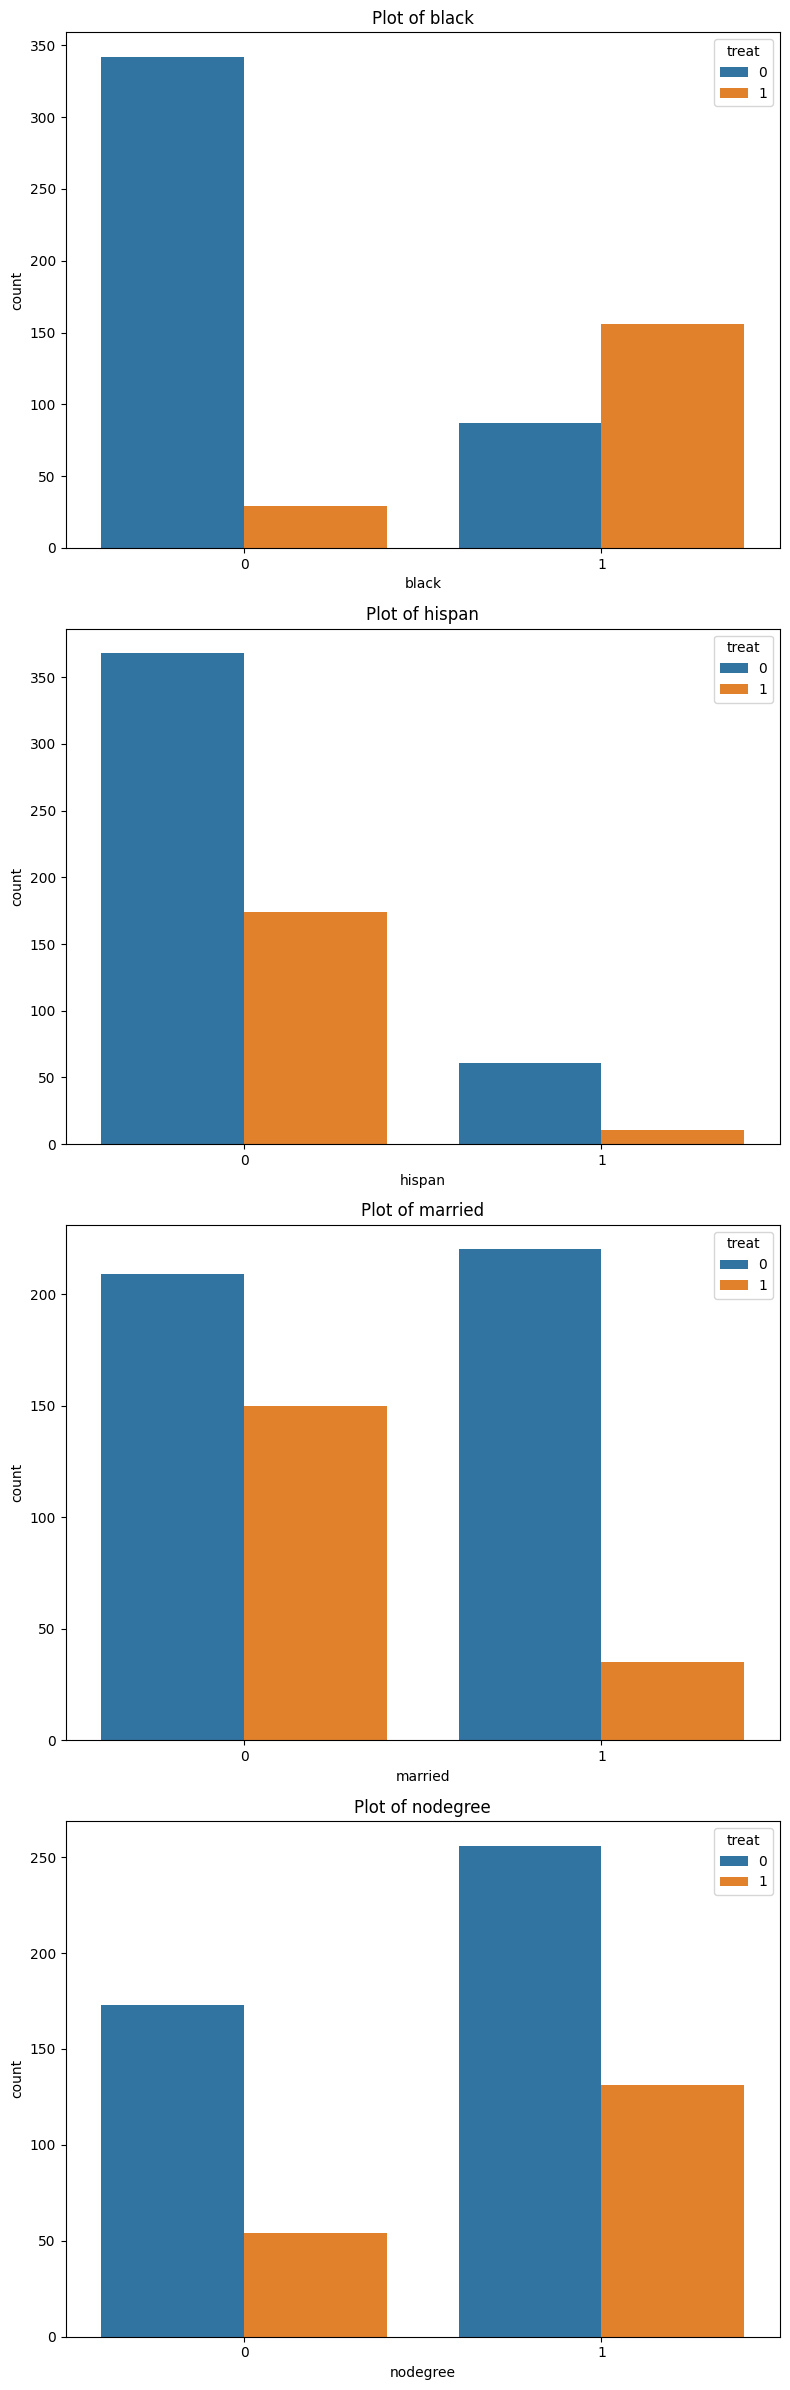

In [7]:
non_numerical_columns = ['black', 'hispan', 'married', 'nodegree']
fig, axes = plt.subplots(nrows=len(non_numerical_columns), ncols=1, figsize=(8, 6 * len(non_numerical_columns)))

for i, col in enumerate(non_numerical_columns):
    sns.countplot(data=data, x=col, hue='treat', ax=axes[i])
    axes[i].set_title(f'Plot of {col}')
plt.tight_layout()
plt.show();

As we can see, for the numerical values the distribution of age, education and income (before treatment) is different. Instinctly, all of these factors have a significant imppact on the outcome. In the categorical values, we can observe that the skin color and marriage distributions have a noticeable difference. These differences can affect the outcome dramatically, as they had, and can mislead our inference.

### 1.3 A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum.

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.  
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.)


In [8]:
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
logistic = linear_model.LogisticRegression()

In [61]:
target = data['treat']
features = data.drop(['treat', 'id'], axis=1)
logistic.fit(features, target)
propensity_scores = logistic.predict_proba(features)[:, 1]
data['propensity'] = propensity_scores

### 1.4 Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.  
(Hint: you may explore the `networkx` package in Python for predefined matching functions)  

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.  
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.  

After matching, you have as many treated as you have control subjects.  
Compare the outcomes (`re78`) between the two groups (treated and control).  

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects. What do you observe?  
Are you closer to being able to draw valid conclusions now than you were before?

### Bonus
Also, You can derive a mathematical model for this section. Your optimization problem should maximize the similarity between matched subjects, as captured by their propensity scores. In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

You don't need to implement this model and only need to write an optimization problem and proof theoretically that your model satisfies our goal.

We will use K means in order to find the pairs.

In [63]:
from sklearn.cluster import KMeans

# Create separate dataframes for treated and control groups
treated_df = data[data['treat'] == 1]
control_df = data[data['treat'] == 0]

# Instantiate KMeans with a single cluster
kmeans = KMeans(n_clusters=1)

treated_propensities = treated_df['propensity'].values
control_propensities = control_df['propensity'].values

# Fit the KMeans model to the control propensity scores
kmeans.fit(control_propensities.reshape(-1, 1))

# Obtain the cluster labels for the control group
control_clusters = kmeans.labels_

# Create a dictionary to store matched pairs
matched_pairs = {}

# Iterate through treated subjects
for treated_idx, treated_propensity in enumerate(treated_propensities):
    # Find the control subject with the nearest propensity score in the same cluster
    closest_control_idx = np.argmin(np.abs(treated_propensity - control_propensities - control_clusters * 0.5))
    closest_control_id = control_df.iloc[closest_control_idx]['id']

    # Check if the control subject hasn't already been matched
    if closest_control_id not in matched_pairs.keys():
        matched_pairs[closest_control_id] = treated_df.iloc[treated_idx]['id']

# Update the data frame with matched IDs
for control_id in matched_pairs.keys():
    treated_id = matched_pairs[control_id]
    data.loc[data['id'] == treated_id, 'matched_id'] = control_id
    data.loc[data['id'] == control_id, 'matched_id'] = treated_id


c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Dan\AppData\Local\Temp\ipykernel_7300\3787169426.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'PSID412' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data['id'] == treated_id, 'matched_id'] = control_id


In [64]:
data

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity,matched_id
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.455082,PSID412
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.148304,PSID72
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.732913,PSID367
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.696610,PSID374
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.694131,PSID419
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,PSID425,0,18,11,0,0,0,1,0.0,0.0,10150.5000,0.213881,NSW140
610,PSID426,0,24,1,0,1,1,1,0.0,0.0,19464.6100,0.196196,NaN
611,PSID427,0,21,18,0,0,0,0,0.0,0.0,0.0000,0.079220,NaN
612,PSID428,0,32,5,1,0,1,1,0.0,0.0,187.6713,0.573681,NSW128


As we can see, now for each data point in the treat group, we have a corresponding data point in the control group. Now we do what we did in part 1.2 again if we are doing OK

In [65]:
new_data = data.dropna(subset=['matched_id'])
new_data

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity,matched_id
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.455082,PSID412
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.148304,PSID72
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.732913,PSID367
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.696610,PSID374
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.694131,PSID419
...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,PSID419,0,51,4,1,0,0,1,0.0,0.0,0.0000,0.694670,NSW5
604,PSID420,0,39,2,1,0,1,1,0.0,0.0,964.9555,0.615264,NSW154
607,PSID423,0,27,10,1,0,0,1,0.0,0.0,7543.7940,0.718103,NSW27
609,PSID425,0,18,11,0,0,0,1,0.0,0.0,10150.5000,0.213881,NSW140


c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

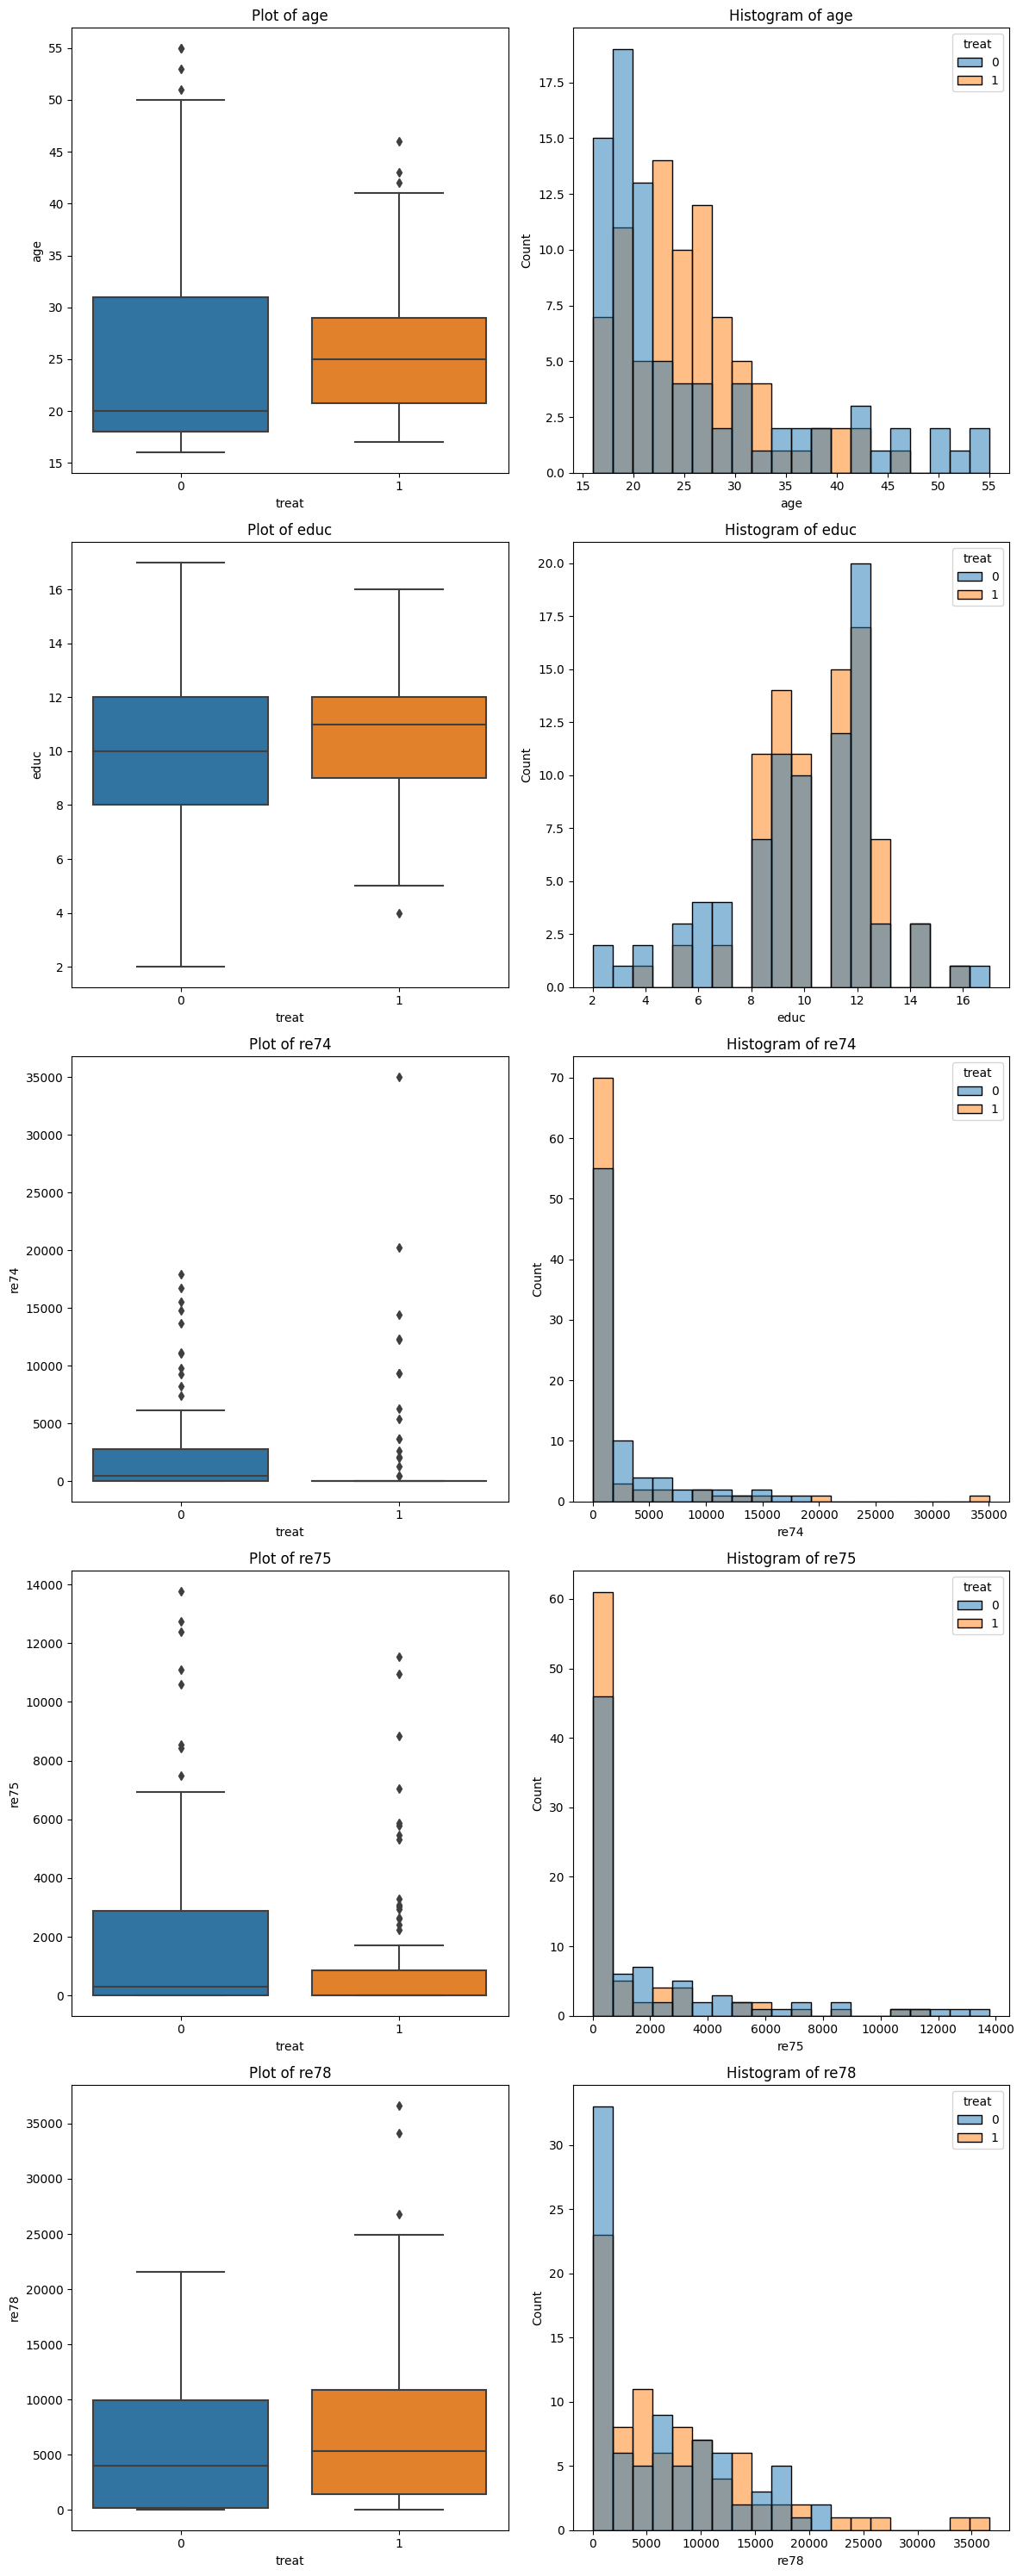

In [68]:
fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=2, figsize=(12, 6 * len(numerical_columns)))

for i, col in enumerate(numerical_columns):
    sns.boxplot(x='treat', y=col, data=new_data, ax=axes[i, 0])
    axes[i, 0].set_title(f'Plot of {col}')
    sns.histplot(data=new_data, x=col, hue='treat', bins=20, kde=False, label=f'treat {col}', ax=axes[i, 1], multiple='layer', alpha=0.5)
    axes[i, 1].set_title(f'Histogram of {col}')

plt.tight_layout()
plt.show();

c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

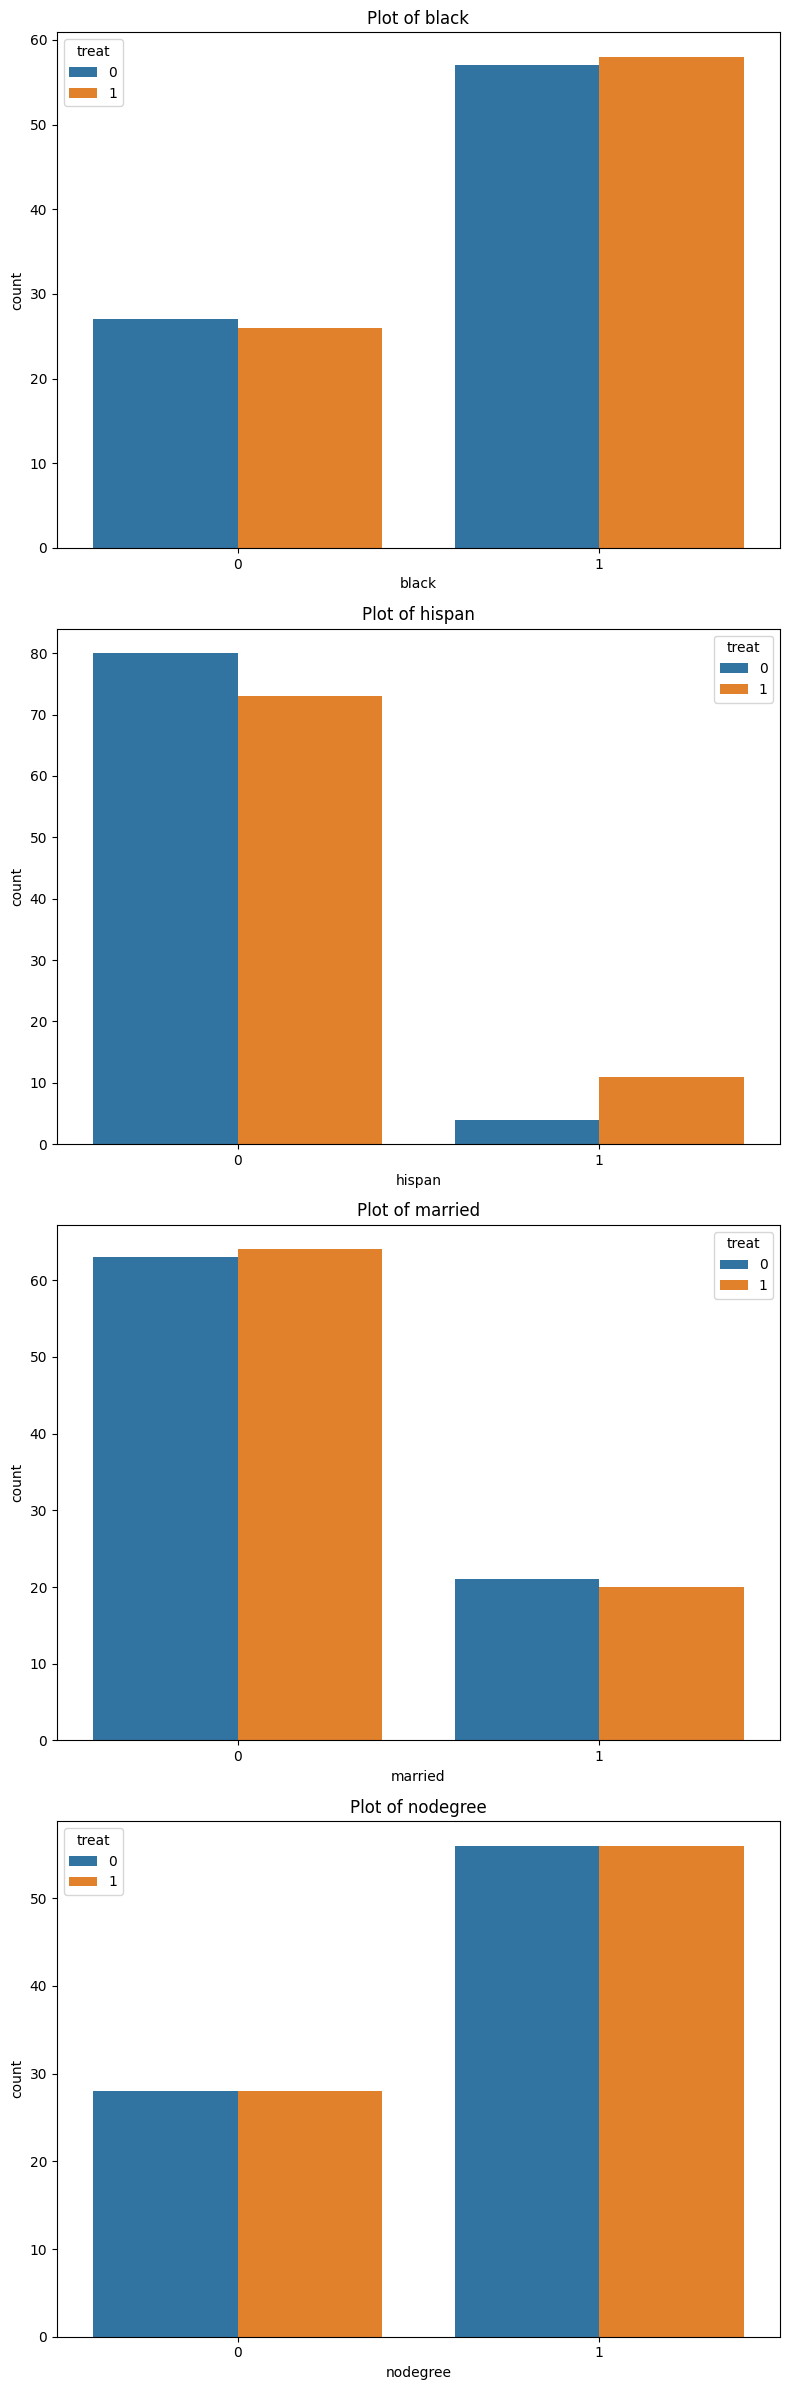

In [69]:
fig, axes = plt.subplots(nrows=len(non_numerical_columns), ncols=1, figsize=(8, 6 * len(non_numerical_columns)))

for i, col in enumerate(non_numerical_columns):
    sns.countplot(data=new_data, x=col, hue='treat', ax=axes[i])
    axes[i].set_title(f'Plot of {col}')
plt.tight_layout()
plt.show();

We can see that the data points are much more better alligned and the distribution is similar for treat and control. Which is what we wanted!

### 1.5 Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?  
Would you say your dataset is sufficiently balanced?  
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?  

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.  
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.



### 1.6 A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?


## 2 Applied Machine Learning with Scikit Learn

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project!  

2.1 Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency (as you will see later in the course), is of great help when it comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).


In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Loading the dataset (all the categories)
newsgroups = fetch_20newsgroups(categories=None, subset='all')

# Making sure all the categories are loaded
print(newsgroups.target_names)

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(newsgroups.data)
y = newsgroups.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


2.2 Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Finding the best hyper parameters
param_grid = {'n_estimators': [5, 10, 20, 50, 100], 'max_depth': [2, 3, 5, 8, 10]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'max_depth': 10, 'n_estimators': 100}


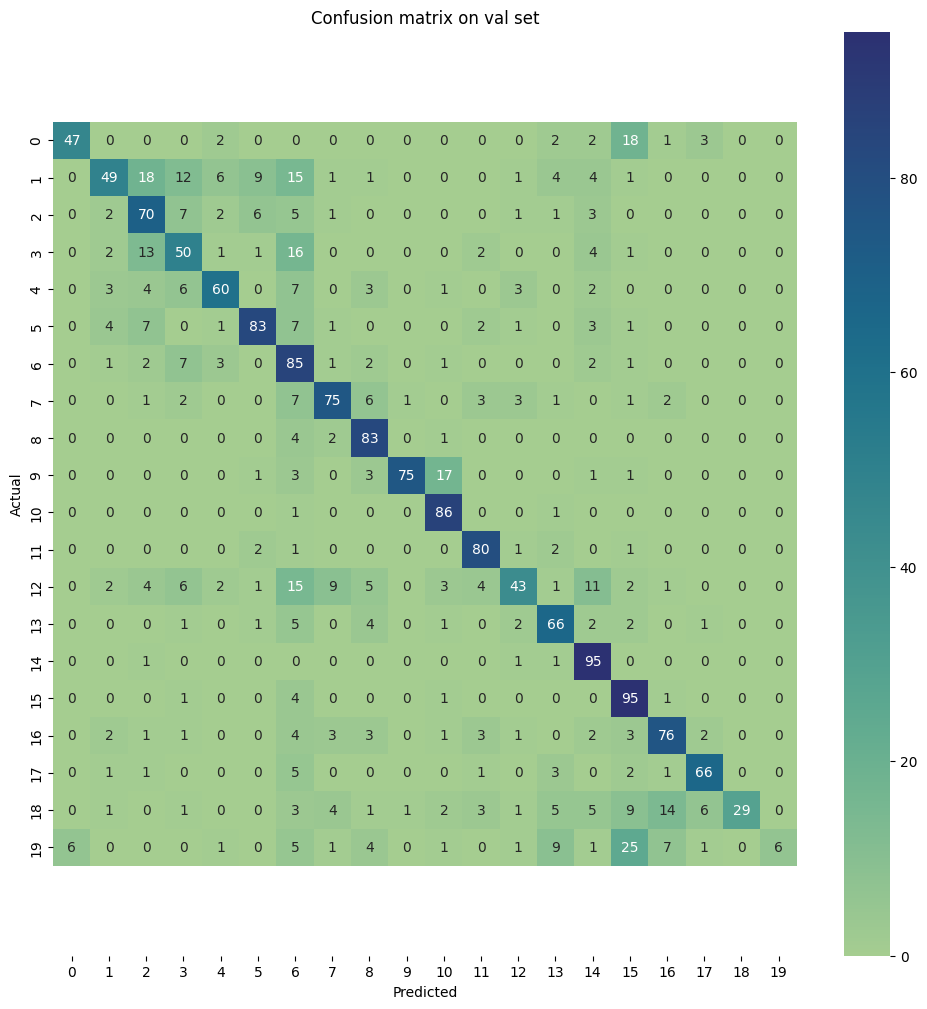

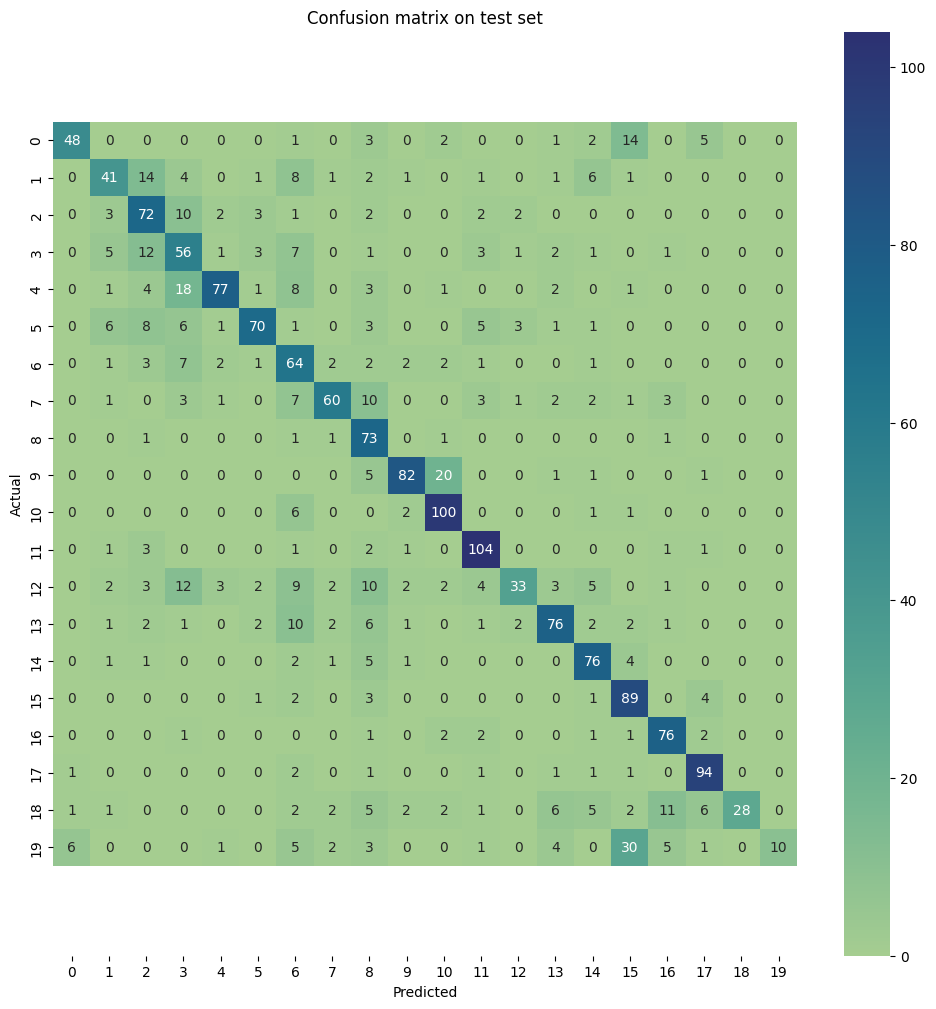

[6.71404498e-06 2.44145319e-05 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [10]:
# Confusion matrix on the validation set
y_pred = grid_search.predict(X_val)
cm1 = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(cm1, annot=True, fmt='g', cmap='crest')
plt.title('Confusion matrix on val set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.axis('equal')
plt.show()

# Train the random forest model on the entire training set using the best parameters
rf_model = RandomForestClassifier(**grid_search.best_params_)
rf_model.fit(X_train, y_train)

# Confusion matrix on the test set
y_pred_test = rf_model.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(12, 12))
sns.heatmap(cm2, annot=True, fmt='g', cmap='crest')
plt.title('Confusion matrix on test set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.axis('equal')
plt.show()

print(rf_model.feature_importances_)

## 3 Regression (Only Numpy, Pandas, Matplotlib Allowed)

### 3.1 Reading Data and Preprocessing

In this section, we want to read data from `regression.csv` CSV file and then preprocess it to make it ready for the rest of the problem.

First, we read the data in the cell below and extract an $m \times n$ matrix, $X$, and an $m \times 1$ vector, $Y$, from it, which represent our knowledge about the building (`X1`, `X2`, ..., `X8`) and heating load (`Y1`), respectively. Note that by $m$, we mean the number of data points and by $n$, we mean the number of features.

In [37]:
data2 = pd.read_csv('regression.csv')
data2.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [38]:
buildings = data2[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']]
heat_load = data2[['Y1']]

Next, we should normalize our data. For normalizing a vector $\mathbf{x}$, a very common method is to use this formula:

$$
\mathbf{x}_{norm} = \dfrac{\mathbf{x} - \overline{\mathbf{x}}}{\sigma_\mathbf{x}}
$$

Here, $\overline{x}$ and $\sigma_\mathbf{x}$ denote the mean and standard deviation of vector $\mathbf{x}$, respectively. Use this formula and store the new $X$ and $Y$ vectors in the cell below.

Briefly explain why we need to normalize our data before starting the training.

In [39]:
means_x = buildings.mean()
std_x = buildings.std()
means_y = heat_load.mean()
std_y = heat_load.std()
X = buildings.copy()
y = heat_load.copy()
for col in X.columns:
    X.loc[:, col] -= means_x[col]
    X.loc[:, col] /= std_x[col]
y.loc[:, 'Y1'] -= means_y['Y1']
y.loc[:, 'Y1'] /= std_y['Y1']

X.head()

,X1,X2,X3,X4,X5,X6,X7,X8
0,2.040447,-1.784712,-0.561586,-1.469119,0.999349,-1.340767,-1.7593,-1.813393
1,2.040447,-1.784712,-0.561586,-1.469119,0.999349,-0.446922,-1.7593,-1.813393
2,2.040447,-1.784712,-0.561586,-1.469119,0.999349,0.446922,-1.7593,-1.813393
3,2.040447,-1.784712,-0.561586,-1.469119,0.999349,1.340767,-1.7593,-1.813393
4,1.284142,-1.228438,0.000000,-1.197897,0.999349,-1.340767,-1.7593,-1.813393


Generally, normalizing the data is good before feeding it to the model. It's good because as we can see, the scale of each feature is different. for instance the X2 values are something around 500 and the X6 values are below 10. This means that if we give the raw data to the model, the coefficients will not be good and the model will not be good eigther. So we normalize to fix this problems.

Finally, we should add a column of $1$ s at the beginning of $X$ to represent the bias term. Do this in the next cell. Note that after this process, $X$ should be an $m \times (n+1)$ matrix.

In [40]:
X['bias'] = np.ones(shape=(len(X), 1))
X = X.to_numpy()

In [41]:
# moving bias to first column
X = np.concatenate((X[:, -1:], X[:, :-1]), axis=1)
X

array([[ 1.        ,  2.040447  , -1.78471183, ..., -1.34076704,
        -1.75930048, -1.81339339],
       [ 1.        ,  2.040447  , -1.78471183, ..., -0.44692235,
        -1.75930048, -1.81339339],
       [ 1.        ,  2.040447  , -1.78471183, ...,  0.44692235,
        -1.75930048, -1.81339339],
       ...,
       [ 1.        , -1.36292406,  1.55293107, ..., -0.44692235,
         1.243239  ,  1.41041708],
       [ 1.        , -1.36292406,  1.55293107, ...,  0.44692235,
         1.243239  ,  1.41041708],
       [ 1.        , -1.36292406,  1.55293107, ...,  1.34076704,
         1.243239  ,  1.41041708]])

### 3.2 Training Model Using Direct Method

We know that the loss function in linear regression is defined as:

$$
\mathcal{L}(\mathbf{w}) = \frac{1}{m}\sum_{i=1}^{m}(\mathbf{w}^\top\mathbf{x}_i-y_i)^2
$$

Here, $w$ is the weight vector and $(x_i, y_i)$ represents the $i$ th data point. First, write a function that takes $X$, $Y$, and $w$ as inputs and returns the loss value in the next cell. Note that your implementation should be fully vectorized, meaning that you are not allowed to use any loops in your function and should only use functions prepared in the numpy library.

In [57]:
def loss_(X, y, weights):
    y_pred = X @ weights
    error = (y - y_pred)**2
    mse = np.mean(error)
    return mse

Now, we want to calculate the weight matrix, $w$, using the direct method. By direct method, we mean finding the answer to the optimization problem below directly using linear algebra, without using iterative methods:

$$
\min_{w} \mathcal{L}(w)
$$

What is the answer to this problem in terms of $X$ and $Y$?

$$
w = (X^T X)^{-1} X^T y
$$

Now you should implement a function that receives $X$ and $Y$ as input and returns $w$. Note that your implementation should also be fully vectorized.

In [58]:
def find_weights1(X, y):
    w = X.T @ X
    w = np.linalg.inv(w)
    w = w @ X.T
    w = w @ y
    return w

Finally, we want to evaluate our loss for this problem. Run the cell below to calculate the loss of your model.

In [59]:
weights = find_weights1(X, y)
loss = loss_(X, y, weights)
print(loss)

0.10409636127254422


### 3.3 Training Model Using Gradient Descent

Now, instead of using the direct method to calculate $w$, we want to use the **Gradient Descent** algorithm. We know that in this algorithm, in each iteration, we should update our weight vector with:

$$
\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \alpha \nabla \mathcal{L}(\mathbf{w}^{(t)})
$$

Here, $w^{t}$ represents the weight matrix in the $t$ th iteration, and $\alpha$ represents the learning rate.
Write an expression for $\nabla\mathcal{L}(\mathbf{w})$.

$$
∂MSE/∂wᵢ = -(2/n) Σᵢ(yᵢ - ŷᵢ)xᵢ
$$

Now, write a function that computes the gradient of $\mathcal{L}(\mathbf{w})$. This function should receive $X$, $Y$, and $\mathbf{w}$ as inputs and return an $(n+1) \times 1$ vector, which represents $\nabla\mathcal{L}(\mathbf{w})$. Note that your implementation should also be **fully vectorized**.

Now, we are ready to implement the Gradient Descent algorithm. Complete the function below for this purpose. Note that this function receives $X$, $Y$, the learning rate, and the number of iterations as inputs. This function should return two parameters. The first parameter is $\mathbf{w}$, and the second parameter is a `numpy` array that contains the loss in each iteration. This array is indicated by `loss_history` in the code. Also note that you should initialize $\mathbf{w}$ with the `randn` function.

In [60]:
def GD(X, y, lr, num_iter):
    losses = []
    n = len(y)
    W = np.zeros((X.shape[1], 1))
    for _ in range(num_iter):
        error = loss_(X, y, W)
        gradient = (2/n) * np.dot(X.T, (np.dot(X, W) - y))
        W = W - lr * gradient
        losses.append(error)
    return W, losses

Now, run the `gradient_descent` function for 5 different values of the learning rate. Plot the `loss_history` of these 5 different values in the same figure. Discuss the effect of the learning rate and find the best value of this parameter.

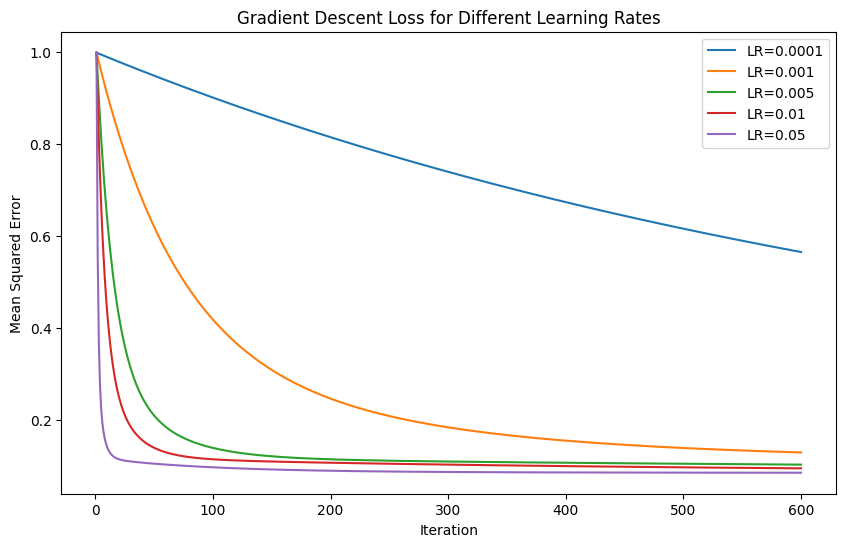

In [64]:
lr_grid = [0.0001, 0.001, 0.005, 0.01, 0.05]
fig, ax = plt.subplots(figsize=(10, 6))
for lr in lr_grid:
    _, losses = GD(X, y, lr, 600)
    ax.plot(range(1, len(losses) + 1), losses, label=f'LR={lr}')
ax.set_xlabel('Iteration')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Gradient Descent Loss for Different Learning Rates')
ax.legend()
plt.show()

### 3.4 Conclusion

Compare the answer of two different methods that we used earlier.

Discuss these two methods and compare them with each other. When is it better to use the direct method, and when is it better to use Gradient Descent?

As we can see, we can reach to the optimal answer using gradient descent with a good learning rate. In this specific problem where our task is just a simple linear regression, it is obviously better to take the analytical approach. However if we are doing something harder and more complex we should use GD.

## 4 Classification (Only Numpy, Pandas, Matplotlib Allowed)
### 4.1 Reading Data and Preprocessing

In this part of the assignment, you should read data from the `.npy` files. The data in `Q4-train.npy` file is your training set and should be stored in the `X_train` and `Y_train` variables. Similarly, the data in `Q4-valid.npy` file is your validation set, and the data in `Q4-test.npy` file is your test set, which should be stored in `X_val`, `Y_val`, `X_test`, and `Y_test` respectively. You can use the `np.load` function to read the `.npy` files.

In [65]:
train = np.load('./Q4-train.npy')
valid = np.load('./Q4-valid.npy')
test = np.load('./Q4-test.npy')

In [73]:
X_train, Y_train = train[:, 0], train[:, 1]
X_val, Y_val = valid[:, 0], valid[:, 1]
X_test, Y_test = test[:, 0], test[:, 1]

To find the best value of `k`, we want to change `k` from 1 to 12 and examine its effect on the validation set, and then choose the right value of `k`. For this purpose, we need to create a matrix with columns equal to $x^0$, $x^1$, $x^2$, ..., $x^k$ for every value of `k`. You can complete the following function to do this job. The function takes an $m \times 1$ vector `X` containing values of input `x` and returns an $m \times (k+1)$ matrix that has the properties mentioned above.

In [71]:
def create_poly_matrix(X, k):
    m = len(X)
    poly_matrix = np.zeros((m, k + 1))
    for i in range(k + 1):
        poly_matrix[:, i] = X**i
    return poly_matrix

### 4.2 Validate Model

Now, we want to train our model for every value of `k`. You can use any of the methods that we used in **Part 3** (gradient descent or direct calculation) for this purpose. The following function trains our model on the training set for a given value of `k`, and then returns the loss on the training set and validation set, as well as the weight vector `w`.

In [72]:
def train_and_evaluate(X_train, Y_train, X_val, Y_val, max_k):
    losses_train = []
    losses_val = []
    weights = []
    for k in range(1, max_k + 1):
        X_train_poly = create_poly_matrix(X_train, k)
        X_val_poly = create_poly_matrix(X_val, k)
        
        w = find_weights1(X_train_poly, Y_train)

        loss_train = loss_(X_train_poly, Y_train, w)
        loss_val = loss_(X_val_poly, Y_val, w)

        losses_train.append(loss_train)
        losses_val.append(loss_val)
        weights.append(w)

    return losses_train, losses_val, weights

In the cell below, you can change the value of `k` between 1 and 12 and plot the loss on the training and validation set as a function of `k` in the same plot. Discuss about the effect of $k$.

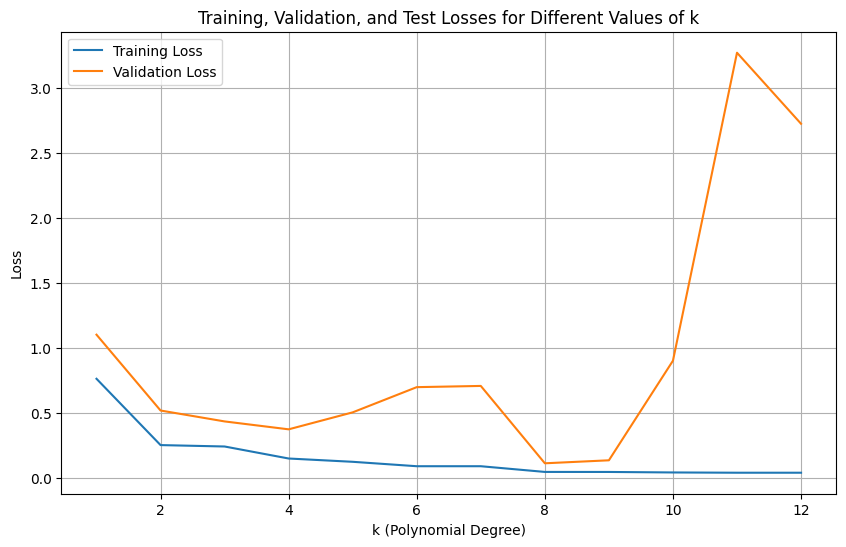

In [78]:
k_values = range(1, 13)
losses_train = []
losses_val = []
weights = []
for k in k_values:
    X_train_poly = create_poly_matrix(X_train, k)
    X_val_poly = create_poly_matrix(X_val, k)
    X_test_poly = create_poly_matrix(X_test, k)

    w = find_weights1(X_train_poly, Y_train)
    weights.append(w)

    loss_train = np.mean((X_train_poly @ w - Y_train)**2)
    loss_val = np.mean((X_val_poly @ w - Y_val)**2)
    loss_test = np.mean((X_test_poly @ w - Y_test)**2)

    losses_train.append(loss_train)
    losses_val.append(loss_val)

plt.figure(figsize=(10, 6))
plt.plot(k_values, losses_train, label='Training Loss')
plt.plot(k_values, losses_val, label='Validation Loss')
plt.title('Training, Validation, and Test Losses for Different Values of k')
plt.xlabel('k (Polynomial Degree)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 4.3 Evaluating Model

In the cell below find the loss of your best model on the test set. Why we need test set?

In [79]:
best_k = np.argmin(losses_val) + 1
best_weights = weights[best_k - 1]
X_test_poly = create_poly_matrix(X_test, best_k)
loss_test = loss_(X_test_poly, Y_test, best_weights)

print(f"Loss on the test set for k={best_k}: {loss_test}")

Loss on the test set for k=8: 0.11791424797209024


## Bonus. CAT or PERSON: Data Sources and Introduction to Pytorch
The purpose of this exercise is two-fold. First, you create an image dataset inheriting from `torch.utils.data.Dataset` by collecting images from two webpages providing AI-generated images to the public. This helps you to understand how data needed for a data science task might come from various sources other than locally stored images, structured files (like CSV), relational databases, etc. Also, people sometimes need to create their custom dataset for their research purposes. In the second part, you will train a neural network on the data using the pytorch framework.


### 5.1 Installing Pytorch

Your job for this section is to install pytorch and the torchvision library. You may normally need torchvision in this exercise when handling images for converting images to torch tensors. For the sake of practicing, it might be good to try installing the libraries directly from your notebook. However, you can also do it from your system shell. Whatever you do, please share your work and the installation success message below. If executing shell commands for installation please share the screenshot of your terminal.

In [3]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import requests
from io import BytesIO
import torchvision.transforms as transforms

### 5.2 Dataset
Take a look at [this interesting webpage](https://thisxdoesnotexist.com/) which shares AI-generated images and have some fun first! Well, we want to collect a dataset consisting of 50 images from [this url](https://thispersondoesnotexist.com/image) created by Phillip Wang and 50 images from [this one](https://thiscatdoesnotexist.com) created by Ryan Hoover. 
For creating the dataset you must inherit from `torch.utils.data.Dataset` and name your custom dataset class as `collected_2class_Dataset`

The `__init__()`, `__len__()` and `__getitem__()` methods of the class must be rewritten by you properly. 

The dataset must be designed in a way that by instantiation of the class, the data collection starts until all the samples are gathered. Your `__getitem__()` should also be coded in a way that `__getitem__(idx)` returns the data sample with the index `idx`. More precisely if your instance of `collected_2class_Dataset` is named `DS` and if:

`img, label = DS.__getitem__(someIndex)`, Then:

* `img` should be a torch tensor of size [1, 784] with data type float. The values must represent the scaled (to [0,1]) pixel values of the grayscale version of the images after being resized to 28x28.  
* `label` should be a torch tensor of a single element with data type long taking the value of 0 if the image is for a person and 1 if the image is related to a cat.

You might need to use additional packages like [Pillow](https://pypi.org/project/Pillow/) for image operations. Also, for requesting images from the websites you can follow different approaches. The simplest one might be running proper curl commands as shell commands from inside your python code. Use the following URLs for each resource to GET the images:
* https://thispersondoesnotexist.com/image
* https://thiscatdoesnotexist.com

Write code for your Dataset class definition and also any auxiliary functions if applicable. Please instantiate your class at the end of this code section.

In [2]:
class collected_2class_Dataset(Dataset):
    def __init__(self, num_samples=50, person_url="https://thispersondoesnotexist.com/image", cat_url="https://thiscatdoesnotexist.com"):
        self.num_samples = num_samples
        self.person_url = person_url
        self.cat_url = cat_url
        self.data = []
        self.labels = []

        # Collect images for persons
        for _ in range(num_samples // 2):
            img = self.fetch_image(self.person_url)
            self.data.append(img)
            self.labels.append(0)  # Person label

        # Collect images for cats
        for _ in range(num_samples // 2):
            img = self.fetch_image(self.cat_url)
            self.data.append(img)
            self.labels.append(1)  # Cat label

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        img = torch.from_numpy(self.data[idx]).float() / 255.0  # Scale pixel values to [0, 1]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

    def fetch_image(self, url):
        try:
            response = requests.get(url)
            response.raise_for_status()  # Check for HTTP errors

            img = Image.open(BytesIO(response.content)).convert('L')  # Convert to grayscale
            img = img.resize((28, 28))  # Resize to 28x28
            img_array = torch.tensor(np.array(img), dtype=torch.float32)
            img_array = img_array.view(1, -1)  # Flatten to [1, 784]
            return img_array
        except Exception as e:
            print(f"Error fetching image from {url}: {e}")
            return None


# dataset = collected_2class_Dataset(num_samples=100)

The URLs are not working and will give 404 error. I talked with amir soleimani and he said to use the cat dog dataset instead!

In [8]:
import os

class CatDogDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = self._create_file_list()

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_path).convert("RGB")

        label = 0 if "cat" in self.file_list[idx] else 1  # 0 for cat, 1 for dog

        if self.transform:
            image = self.transform(image)

        return image, label

    def _create_file_list(self):
        file_list = [file for file in os.listdir(self.root_dir) if file.endswith(".jpg")]
        return file_list

root_directory = "./data"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset = CatDogDataset(root_dir=root_directory, transform=transform)

### 5.3 Dataloader
Using `torch.utils.data.random_split` split your dataset to train/test with the proportion of 70/30. Based on `torch.utils.data.DataLoader` create a DataLoader for train data and one for test data. The choice of the batch size is up to you, but try to use rational values.

In [9]:
from torch.utils.data import DataLoader, random_split

total_samples = len(dataset)
train_size = int(0.7 * total_samples)
test_size = total_samples - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
print(len(train_loader))
print(len(test_loader))

1094
469


### 5.4 Training a Neural Network Classifier
Inheriting from `torch.nn.Module` create a neural network for classifying the input images to person/cat. Use 2 hidden layers. Employ relu as the non-linearity (activation function) for the both hidden layers and sigmoid for the output. The choice of the number of nodes in the hidden layers is up to you. Train your network with the `torch.nn.CrossEntropyLoss` loss as objective function and use `torch.optim.Adam` as optimizer. Use 10 epochs of learning. Report the accuracy of classification at the end of each learning epoch by printing the values. 

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(200704, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)

        x = self.fc2(x)
        return x

model = CNNModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_correct = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {accuracy}")

Epoch 1/30, Training Accuracy: 0.5733142857142857
Epoch 2/30, Training Accuracy: 0.6584
Epoch 3/30, Training Accuracy: 0.7185142857142857
Epoch 4/30, Training Accuracy: 0.7833142857142857
Epoch 5/30, Training Accuracy: 0.8456571428571429
Epoch 6/30, Training Accuracy: 0.9040571428571429
Epoch 7/30, Training Accuracy: 0.9371428571428572
Epoch 8/30, Training Accuracy: 0.9548
Epoch 9/30, Training Accuracy: 0.9685142857142857
Epoch 10/30, Training Accuracy: 0.9721142857142857
Epoch 11/30, Training Accuracy: 0.9757714285714286
Epoch 12/30, Training Accuracy: 0.98
Epoch 13/30, Training Accuracy: 0.9842857142857143
Epoch 14/30, Training Accuracy: 0.9812
Epoch 15/30, Training Accuracy: 0.9841142857142857
Epoch 16/30, Training Accuracy: 0.9857714285714285
Epoch 17/30, Training Accuracy: 0.9857142857142858
Epoch 18/30, Training Accuracy: 0.9887428571428571
Epoch 19/30, Training Accuracy: 0.9864571428571428
Epoch 20/30, Training Accuracy: 0.9886857142857143
Epoch 21/30, Training Accuracy: 0.98845

### 5.5 Testing the Trained Model
Examine the accuracy of your trained model on the test data prepared in section 3-5 and report the result.

In [13]:
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

test_accuracy = total_correct / total_samples
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.7204


### 5.6 Is it Really Difficult to Distinguish Cats from Humans? 
Can you propose a rather simple rule-based system for doing this classification task? No code is needed for this part, just explain your ideas.

There are some easy classic algorithms that we can use for this, like face detection algorithm. However they will not have the accuracy of the ML model and may not perform well on different kinds of data (different lighting and poses). Generally for this kind of tasks there is not a rule-based approach that can outperform the ML model.